# Scopus 2017 - CiteScore, SNIP and SJR

In [Scopus](https://www.scopus.com/sources),
we can download a single spreadsheet workbook
with all the data they have (titles and metrics)
regarding their free journal rankings and metrics,
provided you're signed in.
As of 2018-09-21, it's a 38MB XLSX file
with a spreadsheet of metrics for each year.

In [1]:
import openpyxl
import pandas as pd
import seaborn as sns
pd.options.display.max_colwidth = 200 # Default is 50
pd.options.display.max_rows = 200 # Default is 60
%matplotlib inline

## Opening the Excel File in Pandas

Pandas have a `read_excel` function that can read with `xlrd`
a spreadsheet in an old XLS file,
loading its data into a Pandas DataFrame.
However, we're not going to use it.

In order to open an OOXML containing spreadsheets from Microsoft Excel
(a.k.a. XLSX) in Python, we'll need another library.
[There's a web page](http://www.python-excel.org)
listing which packages were created to deal with MS Excel files,
stating we should use the
[openpyxl](https://openpyxl.readthedocs.io)
library to load the data we've got.

Which spreadsheets are in the Scopus spreadsheet workbook?

In [2]:
workbook_filename = "CiteScore_Metrics_2011-2017_Download_25May2018.xlsx"
wb = openpyxl.load_workbook(workbook_filename)
wb.sheetnames

['About CiteScore',
 '2017 All',
 'Sheet1',
 '2016 All',
 '2015 All',
 '2014 All',
 '2013 All',
 '2012 All',
 '2011 All',
 'ASJC Codes']

For now, we're mainly interested in the $2017$ worksheet.
Let's see it.

In [3]:
ws2017 = wb["2017 All"]

[There's a documentation](https://openpyxl.readthedocs.io/en/2.6/pandas.html)
on how to convert such a worksheet object
to a Pandas DataFrame instance (as well as the other way around).

In [4]:
data_gen = ws2017.values
info = next(data_gen)
header, *data = data_gen
scopus2017 = pd.DataFrame(data, columns=header).dropna(how="all")

In [5]:
print(info[0])
print(scopus2017.shape)
scopus2017.head().T

CiteScore metrics calculated using data from 30 April, 2018. SNIP and SJR calculated using data from 30 April, 2018
(50182, 21)


,0,1,2,3,4
Scopus SourceID,28773,28773,19434,19434,19434
Title,Ca-A Cancer Journal for Clinicians,Ca-A Cancer Journal for Clinicians,MMWR. Recommendations and reports : Morbidity and mortality weekly report. Recommendations and reports / Centers for Disease Control,MMWR. Recommendations and reports : Morbidity and mortality weekly report. Recommendations and reports / Centers for Disease Control,MMWR. Recommendations and reports : Morbidity and mortality weekly report. Recommendations and reports / Centers for Disease Control
CiteScore,130.47,130.47,63.12,63.12,63.12
Percentile,99,99,99,99,99
Citation Count,16961,16961,1010,1010,1010
Scholarly Output,130,130,16,16,16
Percent Cited,70,70,100,100,100
SNIP,88.164,88.164,32.534,32.534,32.534
SJR,61.786,61.786,34.638,34.638,34.638
RANK,1,1,1,1,1


The first five entries regards to just two journals,
this duplication makes it clear we'll need some cleaning
before we can use this data.

## Splitting the data based on SciELO ISSNs

Our goal is to create a dataset based on Scopus 2017 data
with an extra `SciELO` boolean column
which should just tell if the journal belongs to the SciELO network or not.

### Set of SciELO ISSNs

Based on the ISSN normalization notebook,
we can get a full list of ISSNs in the SciELO network
that are also in the analytics reports
(including the independent and development collections)
with:

In [6]:
network_journals = pd.read_csv("tabs_network/journals.csv")
issns_scielo = set(network_journals["ISSN SciELO"].str.upper().values) \
    .union(*network_journals["ISSN's"].dropna().str.split(";")
                                      .apply(set).values) \
    .union({"0719-448X", "0870-8967", "1316-5216", "1667-8982", "1683-0768",
            "1852-4184", "2183-9174", "2223-7666", "2477-9555", "2993-6797"})
len(issns_scielo)

2303

That's not the number of journals, but the number of distinct ISSNs.
We've got the set of SciELO ISSNs,
including the extra values that regards to ISSN normalization
(for the 2018-09-14 reports version).

### Normalizing the Scopus ISSN

We have two columns for the ISSN in the imported Scopus data,
most of it should be cast from integer to string,
and there are several empty values out there:

In [7]:
scopus2017_issns = pd.concat([scopus2017["Print-ISSN"], scopus2017["E-ISSN"]])
scopus2017_issns_types = scopus2017_issns.apply(type)
scopus2017_issns_types.value_counts()

<class 'int'>         63400
<class 'NoneType'>    30197
<class 'str'>          6767
dtype: int64

Regarding the ISSNs that are written as strings
(mostly because of some letter, which should be `X`),
not even the letter case is normalized:

In [8]:
scopus2017_issns_str = scopus2017_issns[scopus2017_issns_types == str]
print("Not equal to the lower (count): ",
      scopus2017_issns_str[scopus2017_issns_str !=
                           scopus2017_issns_str.str.lower()]
                          .size)
print("Not equal to the upper (entries): ",)
scopus2017_issns_str[scopus2017_issns_str !=
                     scopus2017_issns_str.str.upper()]

Not equal to the lower (count):  6522
Not equal to the upper (entries): 


37969    0322788x
37970    0322788x
25769    1558688x
25770    1558688x
26107    1558691x
dtype: object

A single string entry have some noise, no entry have the `-` separator:

In [9]:
scopus2017_issns_str[~scopus2017_issns_str.str.contains("^[\dXx]{8}$")]

48755    00304565;
dtype: object

The integer entries might have less digits,
they're probably just missing some leading zeros.
There's no integer with more than $8$ digits.

In [10]:
scopscopus2017_issns_int = scopus2017_issns[scopus2017_issns_types == int]
scopscopus2017_issns_int.min(), scopscopus2017_issns_int.max()

(10782, 87569728)

Then this function should be enough to normalize a single ISSN:

In [11]:
def normalize_issn(issn):
    if isinstance(issn, int):
        before, after = divmod(issn, 10000)
        return f"{before:04d}-{after:04d}"
    if isinstance(issn, str):
        return f"{issn[:4]}-{issn[4:8]}".upper()
    return ""

Let's apply this normalization function and add the SciELO column:

In [12]:
scopus2017n = scopus2017.assign(**{
    "Print-ISSN": scopus2017["Print-ISSN"].apply(normalize_issn),
    "E-ISSN": scopus2017["E-ISSN"].apply(normalize_issn),
}).assign(SciELO=lambda df: df["Print-ISSN"].isin(issns_scielo)
                          | df["E-ISSN"].isin(issns_scielo))
print(scopus2017n.shape)
scopus2017n.loc[4095:20000:1570, ["Print-ISSN", "E-ISSN", "SciELO"]]

(50182, 22)


,Print-ISSN,E-ISSN,SciELO
4095,1330-0962,,False
5665,1932-6254,,False
7235,0742-0528,,False
8805,0074-0276,1678-8060,True
10375,0716-9760,0717-6287,True
11945,1941-9899,1941-9902,False
13515,1542-0752,1542-0760,False
15085,0167-2681,,False
16655,1413-8670,,True
18225,1094-6136,,False


### Data de-duplication

The same pair of ISSNs might appear more than once.

1      8434
2      7538
3      4261
4      1957
5       680
6       277
7        90
8        20
9         2
13        1
178       1
dtype: int64

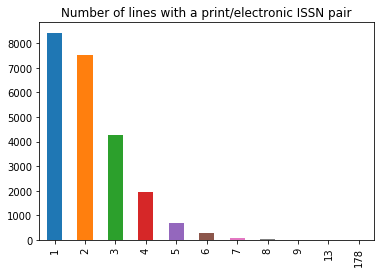

In [13]:
issn_repeat_count = scopus2017n.groupby(["Print-ISSN", "E-ISSN"]) \
                               .size().value_counts()
issn_repeat_count.plot.bar(
    title="Number of lines with a print/electronic ISSN pair"
)
issn_repeat_count

The 178 entries are the empty ones (they have data, but no ISSN).
Such entries aren't in SciELO since they don't have open access:

In [14]:
scopus2017empty = scopus2017n[(scopus2017n["Print-ISSN"] == "") &
                              (scopus2017n["E-ISSN"] == "")]
print(scopus2017empty.shape)
scopus2017empty.groupby("OpenAccess").size()

(178, 22)


OpenAccess
NO    178
dtype: int64

There are duplications in the *Scopus SourceID*, as well.

In [15]:
scopus2017n.columns

Index(['Scopus SourceID', 'Title', 'CiteScore', 'Percentile', 'Citation Count',
       'Scholarly Output', 'Percent Cited', 'SNIP', 'SJR', 'RANK',
       'Rank Out Of', 'Publisher', 'Type', 'OpenAccess',
       'Scopus ASJC Code (Sub-subject Area)', 'Scopus Sub-Subject Area',
       'Quartile', 'Top 10% (CiteScore Percentile)', 'Scopus SourceID',
       'Print-ISSN', 'E-ISSN', 'SciELO'],
      dtype='object')

1     8473
2     7574
3     4284
4     1961
5      680
6      274
7       90
8       20
9        2
13       1
Name: Scopus SourceID, dtype: int64

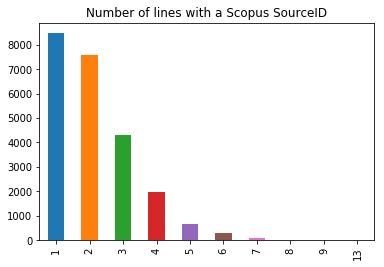

In [16]:
sid_repeat_count = scopus2017n["Scopus SourceID"].iloc[:, -1].value_counts() \
                                                             .value_counts()
sid_repeat_count.plot.bar(title="Number of lines with a Scopus SourceID")
sid_repeat_count

That duplication happens mostly because
multiple subject areas are stored as multiple lines
for the same journal,
and some features are specific to the subject area.
We'll use just some selected columns,
whose projection is enough to get rid
from most duplicated entries.

In [17]:
id_columns = ["Scopus SourceID", "Title", "Print-ISSN", "E-ISSN"]
columns = ["CiteScore", "SNIP", "SJR", "OpenAccess", "SciELO"]
dataset_with_ids = scopus2017n[id_columns + columns].drop_duplicates()

Actually, the Scopus SourceID becomes unique:

In [18]:
dataset_with_ids["Scopus SourceID"].iloc[:, -1].value_counts().value_counts()

1    23359
Name: Scopus SourceID, dtype: int64

But not the ISSNs.
Disregarding the entries without any ISSN, these are the ISSN duplications:

In [19]:
dpi_issns_sizes = dataset_with_ids.groupby(["Print-ISSN", "E-ISSN"]).size()
dpi_issns_duplicated = dpi_issns_sizes[dpi_issns_sizes > 1].drop(("", ""))
dataset_with_ids.reset_index() \
                .set_index(["Print-ISSN", "E-ISSN"]) \
                .loc[dpi_issns_duplicated.index.tolist()]

index Scopus SourceID  \
Print-ISSN E-ISSN                             
           2036-5438  30252    2.110079e+10   
           2036-5438  41080    2.110079e+10   
0021-4922             19594    1.302620e+05   
                      21457    2.811700e+04   
0584-8555             22571    2.050020e+10   
                      32768    2.110020e+10   
1672-5123             20473    1.301350e+05   
                      47991    2.110039e+10   
1875-3507             40297    2.110020e+10   
                      43902    2.110020e+10   
2186-7275  2423-8686  34267    2.110078e+10   
           2423-8686  48882    2.651000e+04   

                                                  Scopus SourceID  \
Print-ISSN E-ISSN                                                   
           2036-5438  https://www.scopus.com/sourceid/21100790340   
           2036-5438  https://www.scopus.com/sourceid/21100786380   
0021-4922                  https://www.scopus.com/sourceid/130262   
                            https://www.scopus.com/sourceid/28117   
0584-8555             https://www.scopus.com/sourceid/20500195421   
                      https://www.scopus.com/sourceid/21100201539   
1672-5123                  https://www.scopus.com/sourceid/130135   
                      https://www.scopus.com/sourceid/21100391400   
1875-3507             https://www.scopus.com/sourceid/21100203922   
                      https://www.scopus.com/sourceid/21100201921   
2186-7275  2423-8686  https://www.scopus.com/sourceid/21100778849   
           2423-8686        https://www.scopus.com/sourceid/26510   

                                                                                          Title  \
Print-ISSN E-ISSN                                                                                 
           2036-5438                                                Oxford Medical Case Reports   
           2036-5438                                                 Perspectives on Federalism   
0021-4922             Japanese Journal of Applied Physics, Part 1: Regular Papers & Short Notes   
                                                            Japanese Journal of Applied Physics   
0584-8555                                                                    Chemical Modelling   
                             Spectroscopic Properties of Inorganic and Organometallic Compounds   
1672-5123                                                International Journal of Ophthalmology   
                                                                      International Eye Science   
1875-3507                                                                      IUTAM Bookseries   
                                                           Solid Mechanics and its Applications   
2186-7275  2423-8686                                                    Southeast Asian Studies   
           2423-8686                                Japanese Journal of Southeast Asian Studies   

                      CiteScore   SNIP    SJR OpenAccess  SciELO  
Print-ISSN E-ISSN                                                 
           2036-5438       0.62  0.434  0.178        YES   False  
           2036-5438       0.20  0.395  0.107        YES   False  
0021-4922                  1.28  0.668  0.497         NO   False  
                           1.13  0.865  0.371         NO   False  
0584-8555                  1.06  0.624  0.464         NO   False  
                           0.50  0.163  0.172         NO   False  
1672-5123                  1.21  0.696  0.576        YES   False  
                           0.03  0.021  0.109        YES   False  
1875-3507                  0.22  0.312  0.144         NO   False  
                           0.12  0.176  0.114         NO   False  
2186-7275  2423-8686       0.44  0.868  0.162        YES   False  
           2423-8686       0.00      0  0.101        YES   False

The `2036-5438` and `1672-5123` had been seen
in the SCImagoJR analysis notebook,
the former is probably two distinct sources,
yet the second seem distinct translations
of the same source title in Chinese,
perhaps regarding to distinct moments of the journal.
The *Japanese Journal of Applied Physics* appears twice
as well as the *Japanese Journal of Southeast Asian Studies*.
Some normalization is still required here.
However, these are no more than $5$ entries in $23359$ rows,
and it's quite difficult to know what's going on with these duplications
or which value should be regarded as correct for each column.
For now, we can stand with this noise,
but we could had removed some rows based on index with something like:

```python
dataset_plus_ids.drop([47991, 48882], inplace=True)
```

Where the numbers are the set of `index` values to be removed.

We no longer need the ID columns, so this is our dataset:

In [20]:
dataset = dataset_with_ids[columns]
print(dataset.shape)
dataset.head()

(23359, 5)


,CiteScore,SNIP,SJR,OpenAccess,SciELO
0,130.47,88.164,61.786,NO,False
2,63.12,32.534,34.638,YES,False
6,51.08,11.97,23.414,NO,False
7,39.42,7.967,17.633,NO,False
8,36.13,19.73,33.557,NO,False


A description of the `CiteScore`, `SNIP` and `SJR` columns
can be found in the
[Scopus support/help web page](
  https://service.elsevier.com/app/answers/detail/a_id/14834/supporthub/scopus/
).
There's no empty field in this dataset:

In [21]:
dataset.dropna().shape

(23359, 5)

### Consistency in the SciELO and OpenAccess columns

All SciELO entries should be open,
since that's a criterion for belongingness in the SciELO network.
Yet, some rows are inconsistent in Scopus data
regarding this constraint:

count
OpenAccess SciELO       
NO         False   19152
           True      160
YES        False    3552
           True      495

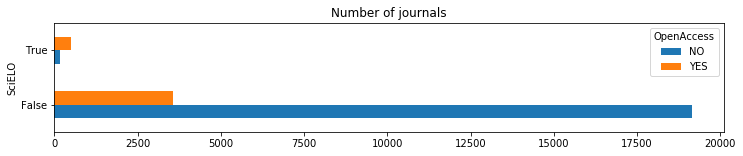

In [22]:
dataset_oscounts = dataset.groupby(["OpenAccess", "SciELO"]).size() \
                          .rename("count")
dataset_oscounts.unstack("OpenAccess") \
                .plot.barh(figsize=(12, 2),
                           title="Number of journals")
pd.DataFrame(dataset_oscounts)

That is, there are journals marked as without open access in Scopus,
but whose ISSN is in the SciELO network.
As it seems,
most titles are matching the ones in the SciELO data
(the empty rows need further normalization to be properly matched).

In [23]:
dataset_ids = dataset_with_ids[(dataset["OpenAccess"] == "NO") &
                               dataset["SciELO"]][id_columns]
dataset_ids_with_scielo_titles = \
    dataset_ids.join(network_journals.set_index("ISSN SciELO")
                         ["title at SciELO"].rename("P-SciELO"),
                     on="Print-ISSN") \
               .join(network_journals.set_index("ISSN SciELO")
                         ["title at SciELO"].rename("E-SciELO"),
                     on="E-ISSN")
pd.concat([
    dataset_ids_with_scielo_titles["Title"],
    (dataset_ids_with_scielo_titles["P-SciELO"].fillna("")
     + dataset_ids_with_scielo_titles["E-SciELO"].fillna("")
    ).rename("Title in SciELO"),
], axis=1).drop_duplicates()

,Title,Title in SciELO
4915,Bulletin of the World Health Organization,Bulletin of the World Health Organization
17404,Journal of the Brazilian Society of Mechanical Sciences and Engineering,Journal of the Brazilian Society of Mechanical Sciences and Engineering
18118,Annals of Hepatology,Annals of Hepatology
19624,Journal of Applied Research and Technology,Journal of applied research and technology
20659,Atmosfera,Atmósfera
20972,Revista Latinoamericana de Psicologia,Revista Latinoamericana de Psicología
21328,Ameghiniana,Ameghiniana
21565,Theoretical and Experimental Plant Physiology,Theoretical and Experimental Plant Physiology
22740,Revista Mexicana de Ingeniera Qumica,Revista mexicana de ingeniería química
23269,South African Journal of Animal Sciences,South African Journal of Animal Science


We should regard these as open access journals.
We can create a `Type` column
with the `SciELO`, `Not SciELO` (but open) and `Closed` types,
which should fix this issue.

In [24]:
datasetf = dataset.assign(
    Type=dataset.T.apply(lambda row:
        "SciELO" if row["SciELO"] else (
            "Not SciELO" if row["OpenAccess"] == "YES"
                         else "Closed"
        )
    )
).drop(columns=["OpenAccess", "SciELO"])
print(datasetf.shape)
datasetf.head()

(23359, 4)


,CiteScore,SNIP,SJR,Type
0,130.47,88.164,61.786,Closed
2,63.12,32.534,34.638,Not SciELO
6,51.08,11.97,23.414,Closed
7,39.42,7.967,17.633,Closed
8,36.13,19.73,33.557,Closed


And now the total count makes more sense.

,Type
Closed,19152
Not SciELO,3552
SciELO,655


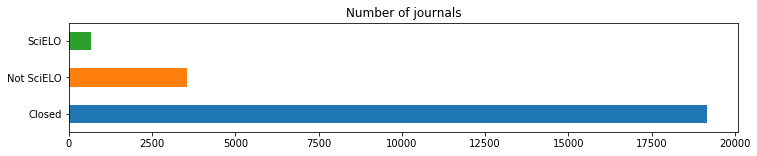

In [25]:
dataset_tcounts = datasetf["Type"].value_counts()
dataset_tcounts.plot.barh(figsize=(12, 2),
                          title="Number of journals")
pd.DataFrame(dataset_tcounts)

### CiteScore, SNIP and SJR

In a tidy format, our data becomes:

In [26]:
datasetf_tidy = (
    datasetf
    .set_index("Type")
    .rename_axis("Measure", axis="columns")
    .stack()
    .rename("Value")
    .replace("-", None) # Empty entries are marked with "-"
    .dropna()
    .astype(float) # Required to avoid breaking Seaborn
    .reset_index()
)
print(datasetf_tidy.shape)
datasetf_tidy.head()

(70077, 3)


,Type,Measure,Value
0,Closed,CiteScore,130.470
1,Closed,SNIP,88.164
2,Closed,SJR,61.786
3,Not SciELO,CiteScore,63.120
4,Not SciELO,SNIP,32.534


Now we can have a boxplot of this data.

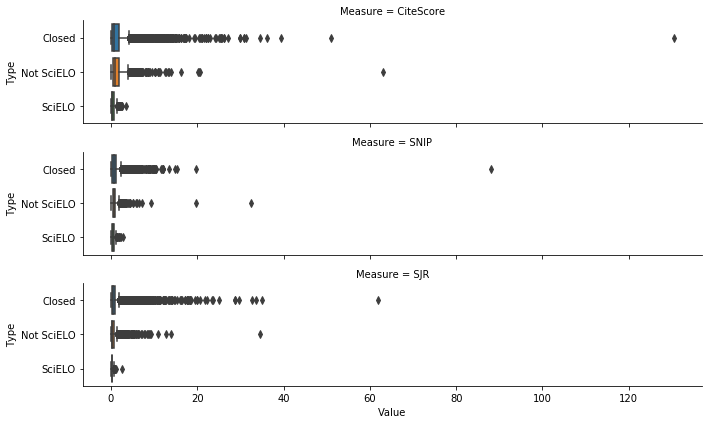

In [27]:
sns.catplot(
    kind="box",
    data=datasetf_tidy,
    row="Measure",
    x="Value",
    y="Type",
    height=2,
    aspect=5,
);

The huge outliers makes it difficult to understand what's going on.
Let's impose some limits to $[0, 40]$ (we won't see these huge outliers).

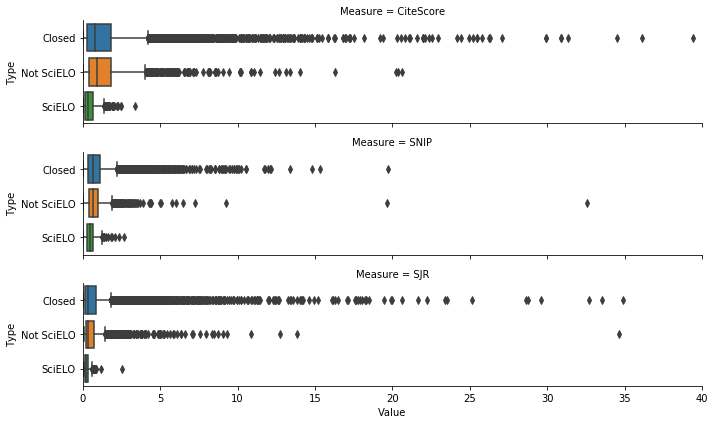

In [28]:
sns.catplot(
    kind="box",
    data=datasetf_tidy,
    row="Measure",
    x="Value",
    y="Type",
    height=2,
    aspect=5,
).set(xlim=[0, 40]);

It's still too high.
Seeing just $[0, 5]$:

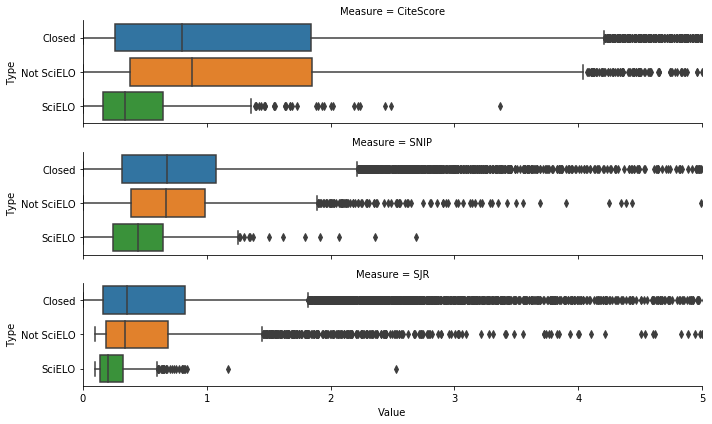

In [29]:
sns.catplot(
    kind="box",
    data=datasetf_tidy,
    row="Measure",
    x="Value",
    y="Type",
    height=2,
    aspect=5,
).set(xlim=[0, 5]);

SciELO data seem to be
either not properly referenced in the Scopus network
(as the ISSN normalization is an issue
 and we saw lots of open access journals not marked as open),
or we have some reason for such smaller values
for the SciELO-matching entries in Scopus.
In the SCImagoJR analysis notebook,
the SJR field had been analyzed,
SJR is higher in most countries SciELO has data,
but mixing all the countries makes a huge difference.